## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the State-Jump sampler.

In [1]:
# general python utility packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

#### TransC class

In [2]:
from pyTransC import TransC_Sampler

In [3]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

In [4]:
def solveLS(d,G,Cdinv,mu=None,Cmpriorinv=None): # Least squares solver
    A = np.dot(np.transpose(G), Cdinv) # Find solution
    GtG = np.dot(A, G) # G^T C_inv G^T
    if(Cmpriorinv is not None) and (mu is not None): GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(A,d)
    if(Cmpriorinv is not None) and (mu is not None): B += np.dot(Cmpriorinv,mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [5]:
def calcE(dp,dobs,Cdinv,Cmpost,m,muprior,Cmpriorinv):
    misfit = 0.5*(np.dot((dobs-dp),np.dot(Cdinv,(dobs-dp))))
    misfit += 0.5*(np.dot((muprior-m),np.dot(Cmpriorinv,(muprior-m))))
    f = np.sqrt(2*np.pi)**len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost*detCdinv*detCmpriorinv)*np.exp(-misfit)/f
    return E

--------

## Polynomial regression set up

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

Minimization of the least squares misfit measure with Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

leads to

$$
\hat{{\bf m}} = \left(\mathbf{G^T} C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G^T}  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$

In [6]:
def getG(x,order): # build design matrix, G for polynomial data fitting, at data points x up to order order
    return np.transpose([x**(i) for i in range(order+1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [7]:
np.random.seed(61254557)
ndata,sigma = 20,0.2
xobs = np.sort(np.random.rand(ndata)) # x values of data
mtrue = np.array([0.3,0.6])
G = getG(xobs,1)
dobs = np.dot(G,mtrue) + np.random.normal(0,sigma,size=len(xobs))
Cdinv = np.eye(ndata)/(sigma**2)

Set up prior for Evidence calculation.

In [8]:
mls, Cmpost, G, Ev, maxorder = [],[], [], [], 3
Cmprior = [20*np.eye(i+1) for i in np.arange(maxorder+1)]
Cmpriorinv = [0.05*np.eye(i+1) for i in np.arange(maxorder+1)]
muprior = [np.zeros(i+1) for i in np.arange(maxorder+1)]

Solve least squares solution and calculate evidence for each model.

In [9]:
for i in range(maxorder+1):
    Gp = getG(xobs,i)
    solp, Cmp = solveLS(dobs,Gp,Cdinv)
    dpred = np.dot(Gp,solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(dobs,Gp,Cdinv,mu=muprior[i],Cmpriorinv=Cmpriorinv[i])
    Ev.append(calcE(dpred,dobs,Cdinv,Cmp2,solp2,muprior[i],Cmpriorinv[i]))
Ev/=np.sum(Ev)

Plot solutions.

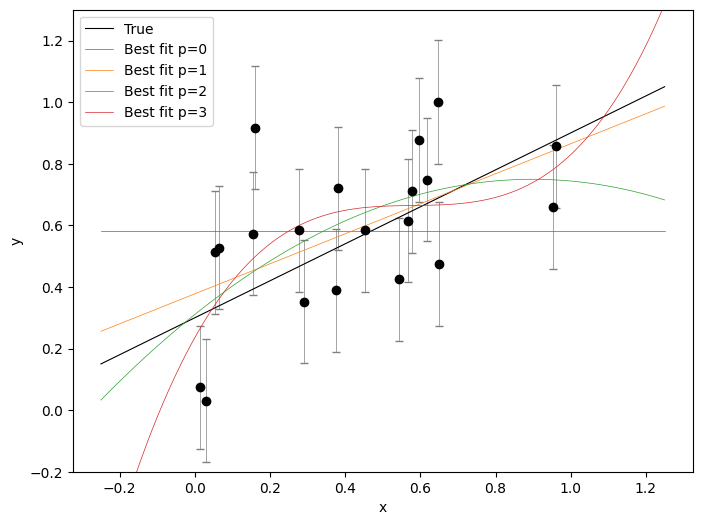

In [10]:
xplot = np.linspace(-0.25,1.25,100)
Gplot = getG(xplot,1)
dplot = np.dot(Gplot,mtrue)
#
plt.figure(figsize=(8,6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt='ko', ecolor = "grey",lw=0.5)
plt.plot(xplot,dplot,label='True',color='k',lw=0.8)
for i in range(maxorder+1):
    Gplotp = getG(xplot,i)
    dpred = np.dot(Gplotp,mls[i])
    plt.plot(xplot,dpred,label='Best fit p='+str(i),lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-0.2,1.3)
plt.legend()
plt.show()

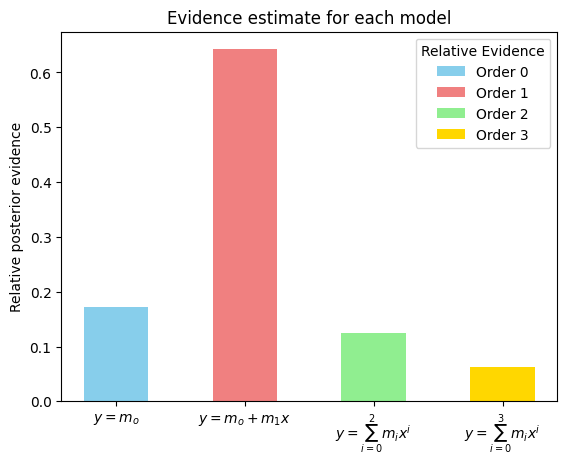

In [12]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
counts = [Ev[i] for i in range(maxorder+1)]
bar_labels = ['Order 0','Order 1', 'Order 2', 'Order 3'] # Define a list of labels, one for each bar

bar_colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'] # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5,color=bar_colors)

ax.set_ylabel('Relative posterior evidence')
ax.set_title('Evidence estimate for each model')
ax.legend(title='Relative Evidence')

plt.show()

In [13]:
Ev

array([0.17163235, 0.64217786, 0.12414475, 0.06204504])

----------------

Set some global control parameters.

In [14]:
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [15]:
def log_Likelihood(x,state,dobs,G,Cdinv):
    dpred = np.dot(G[state],x)
    misfit = 0.5*(np.dot((dobs-dpred),np.dot(Cdinv,(dobs-dpred))))
    f = np.sqrt(2*np.pi)**len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) -misfit + np.log(detCdinv)
    return logL

In [16]:
def log_prior(x,state,muprior,Cmprior):
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(mean=mu,cov=cov) # instance of multi-dimensional Gaussian
    return rv.logpdf(x)

In [17]:
def log_posterior(x,state,dobs,G, Cdinv, muprior, Cmprior): # Multi-state log Posterior PDF evaluation (unormalised)
    return log_Likelihood(x,state,dobs,G,Cdinv) + log_prior(x,state,muprior,Cmprior)
log_posterior_args = [dobs,G,Cdinv,muprior,Cmprior]

### Starting points for MCMC samplers in each state

In [18]:
# first we optimize each state to find good starting point for all McMC samplers
np.random.seed(42)
nstates = maxorder+1               # Number of distinct states
ndims  = [1,2,3,4]                 # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5*np.ones(i+1)
    soln = minimize(nll, initial, args=(i,dobs,G,Cdinv,muprior,Cmprior))
    ml.append(soln.x)
    print("x_ml ",soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Pseudo-prior for each state

Here we use a fixed Gaussian pseudo prior for each state, which can be difficult to decide in advance.

In [19]:
Cmpseudo = [20*np.eye(i+1) for i in np.arange(maxorder+1)]  # Covariances of pseudo priors
mupseudo = [np.zeros(i+1) for i in np.arange(maxorder+1)]
#mupseudo = [0.2*np.ones(i+1) for i in np.arange(maxorder+1)] # offset means of pseudo priors as a test
def log_pseudo_prior(x,state,mupseudo,Cmpseudo,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
    mu = mupseudo[state]                  # Gaussian mean for current state
    cov = Cmpseudo[state]            # covariance matrices for current state
    rv = stats.multivariate_normal(mean=mu,cov=cov) # instance of multi-dimensional Gaussian
    if(returndeviate):
        x = rv.rvs() # generate deviate of multi-dimensional Gaussian
        logppx = rv.logpdf(x) # log amplitude of multi-dimensional Gaussian
        if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case where rv returns a scalar
        return logppx,x
    else:
        return rv.logpdf(x) # log amplitude of multi-dimensional Gaussian 

log_pseudo_prior_args = [mupseudo,Cmpseudo]   # additional argument list beyond (x,state)    

Here we use an automatic pseudo prior for each state which corresponds to a best fit multi-dimensional Gaussian to posterior ensembles in each state.

This is built using the class function `TransC_Sampler.build_auto_pseudo_prior()` which returns a function which we'll call `log_pseudo_prior()`. 
This function can be called in two ways:

- Firstly, with the call sequence `logPDF = log_pseudo_prior(x,state)`, where it evaluates the normalised log pseudo prior for point `x` in state `state`;
- Secondly, with the call sequence `logPDF, deviate = TransC_Sampler.build_auto_pseudo_prior(NULL,state,returndeviate=True)`, where it generates a random deviate from the pseudo-prior and calculates its logPDF.

In [20]:
# This generates posterior samples in each state and fits a Gaussain to them to becomne the pseudo prior
nwalkers_auto = 32                                              # Number of walkers for auto pseudo prior fitting
nsteps_auto = 1000                                              # Number of chain steps for auto pseudo prior fitting
autothin = True                                                 # Thin internally generated within state posterior ensembles by their auto-correlation 
                                                                # (This can take additional compute time, and is not necessary if input ensembles are already independent.)
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_auto, ndims[i])) # add random perturbation to maximum Likelihood models
    
tcs = TransC_Sampler(nstates,ndims) # create instance of sampler
log_pseudo_prior = tcs.build_auto_pseudo_prior(pos,log_posterior,
                                               log_posterior_args=log_posterior_args,
                                               nwalkers=nwalkers_auto,
                                               nsamples=nsteps_auto,
                                               autothin=autothin,
                                               parallel=parallel)

-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping across model states with the State-Jump sampler 

Here we demonstrate use of the *State-jump sampler*.

This formulation is equivalent to the *Product-space sampler* with the proposal for the other state variables equal to the pseudo prior, for which moves are then accepted with probability one. As a consequence  the only pair of model states that need be considered are the $k$ and $k^{\prime}$ states (i.e. same as in Reversible-Jump). 

- For within-state moves the acceptance is the usual M-H condition with proposal = to users choice for that state, defined by routine `log_proposal`
  This can be any perturbative proposal PDF designed by the user, or an automatic one found by fitting a Gaussian mixture model to some trial samples. (The class function `build_pseudo_prior` can be used to do this.)

- For between-state moves we assume that only the state index changes, $k \rightarrow k^{\prime}$ , and hence the model in state $k^{\prime}$ must be a draw from the pseduo prior for that state. The acceptance term then only involves the likelihood ratio and the pseudo prior ratio for the two states.


In [21]:
# define model proposal for within state moves
def log_proposal(xc,state):  # defines an isotropic Gaussian model perturbation within each state
    std =  [[0.01],
            [0.04,0.05],
            [0.04,0.2,0.2],
            [0.05,0.5,1.0,1.0]]   # Proposal variance for each parameter in state
    i = np.random.choice(np.arange(len(xc)))
    var = std[state][i]**2
    x = np.copy(xc)
    x[i] += stats.multivariate_normal.rvs(mean=0.0,cov=var) # spherical multi-dimensional Gaussian
    logpert = 0.0 # log ratio for symmetric proposal
    if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case which returns a scalar
    return logpert,x # return log of pseudo prior density and location (as 1D array)
    
log_proposal_args = []    # additional argument list beyond (x,state)

In [22]:
# perform initiation of IS-sampler
tc = TransC_Sampler(nstates,ndims) # Create instances of states

In [23]:
# starting points of MCMC chains
nwalkers_sj = 32                                               # Number of walkers 
nsteps_sj = 10000                                              # Number of chain steps
pos_states = np.random.choice(np.arange(nstates),nwalkers_sj)  # Initial states of each walker
pos = []
for i in range(nwalkers_sj): # generate starting points for each walker
    pos.append(ml[pos_states[i]] + 1e-4 * np.random.randn(ndims[pos_states[i]])) # add random perturbation to maximum Likelihood models

In [24]:
start_time = time.time()
tc.run_state_jump_sampler(nwalkers_sj,
                 nsteps_sj,
                 pos,
                 pos_states,
                 log_posterior,
                 log_pseudo_prior,
                 log_proposal,
                 log_posterior_args=log_posterior_args,
                 parallel=parallel,
                 progress=True)
elapsed_time = time.time() - start_time


Running state-jump trans-C sampler

Number of walkers               :  32
Number of states being sampled  :  4
Dimensions of each state        :  [1, 2, 3, 4]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:02<00:00,  1.95s/it]


In [25]:
# print some diagnostics
key = tc
print('\n Algorithm type                                   :', key.alg)
# extract trans-D samples and chains
discard = 0                  # chain burnin
thin = 20                    # chain thinning
chain,states_chain = key.get_visits_to_states(discard=discard,thin=thin,normalize=True,walker_average='median',return_samples=True)

print('\n Total number of state changes for all walkers    :',key.total_state_changes)
print('\n Number of state changes for each walker          :\n',*key.state_changes_perwalker)
print('\n Acceptance rates for walkers within states:  \n',key.accept_within_per_walker,'\n')
print(' Acceptance rates for walkers between states: \n',key.accept_between_per_walker,'\n')
print(' Average % acceptance rate for within states      :',np.round(key.accept_within,2))
print(' Average % acceptance rate for between states     :',np.round(key.accept_between,2))
print(' Auto correlation time for between state sampling :',np.round(key.autocorr_time_for_between_state_jumps,3))
print(' Analytical relative marginal Likelihoods         :', *np.round(Ev,5))
print(' Estimated relative evidences                     :', *np.round(key.relative_marginal_likelihoods,5))
print(' Elapsed time.                                    :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                   : TransC-state-jump-sampler

 Total number of state changes for all walkers    : 6252

 Number of state changes for each walker          :
 187 216 212 191 188 205 195 194 218 199 172 203 200 181 199 175 202 203 176 211 187 191 194 199 193 183 164 219 200 177 211 207

 Acceptance rates for walkers within states:  
 [0.76078737 0.75559247 0.75599467 0.75416389 0.74676628 0.75679574
 0.74672586 0.76154445 0.75467498 0.75240837 0.77711044 0.75655765
 0.76314327 0.76320462 0.77355556 0.7750919  0.75457711 0.75335626
 0.75448903 0.74384018 0.75755211 0.76302633 0.74266416 0.76050233
 0.75996907 0.75416574 0.7626912  0.75544929 0.74405423 0.76082589
 0.76956281 0.75783507] 

 Acceptance rates for walkers between states: 
 [0.36607143 0.43092784 0.38205645 0.39134809 0.38953488 0.40324215
 0.41010101 0.36623889 0.42716535 0.3880289  0.33795837 0.39481268
 0.39182453 0.36336032 0.392      0.35874878 0.36645397 0.39817629
 0.37730061 0.38181818

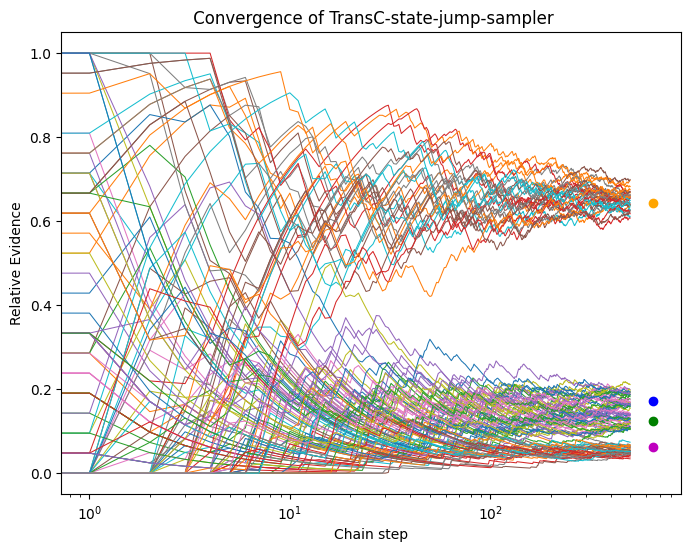

In [26]:
# plot relative number of visits to each state along the chain
if(plotting):
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    plt.plot(len(chain)*1.3,Ev[0],'bo')
    plt.plot(len(chain)*1.3,Ev[1],'o',color='orange')
    plt.plot(len(chain)*1.3,Ev[2],'go')
    plt.plot(len(chain)*1.3,Ev[3],'mo')
    plt.title(' Convergence of '+key.alg)
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains are 
converging, and visiting each state in proportion to the correct normalization constant. 

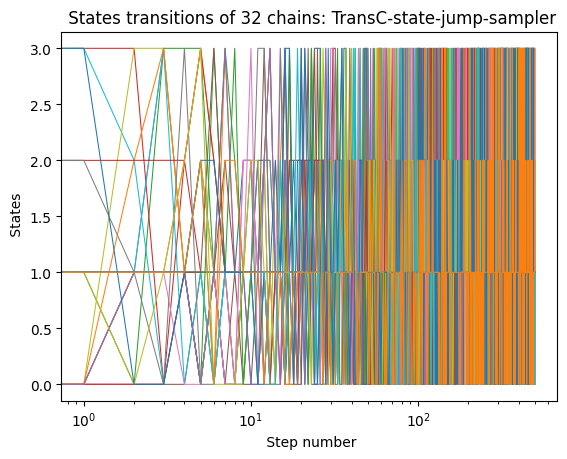

In [27]:
# plot chain states
if(plotting):
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0],-1),lw=0.75)
    plt.xlabel(' Step number')
    plt.ylabel(' States')
    title = ' States transitions of '+str(nwalkers_sj)+' chains: '+key.alg
    plt.title(title)
    plt.show()

This plot shows the movement of each chain between states.

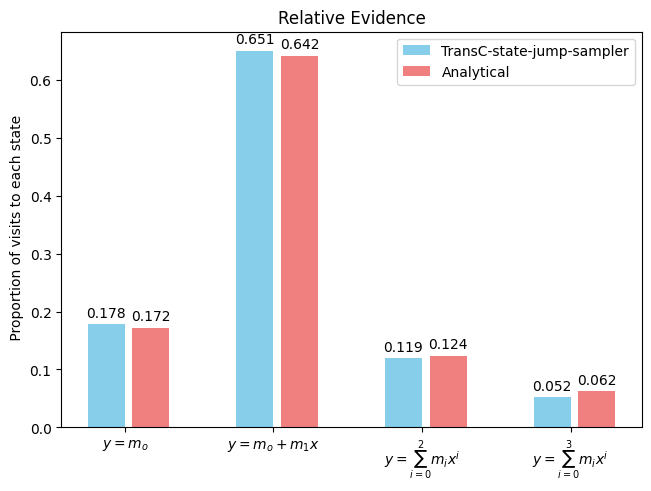

In [28]:
# Count visits to each state by Trans-D mcmc
if(plotting):
    h=np.zeros(key.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=key.alg,color='skyblue')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    rects = ax.bar(x + offset, np.round(counts,3), width, label='Analytical',color='lightcoral')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


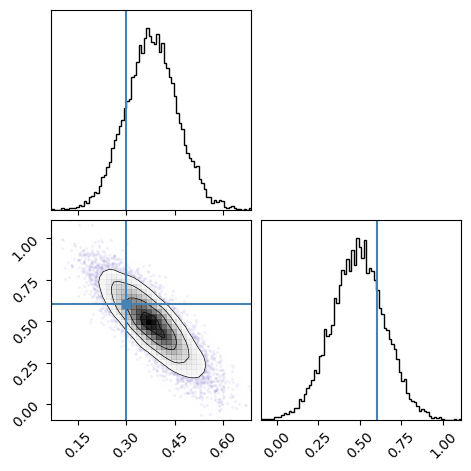

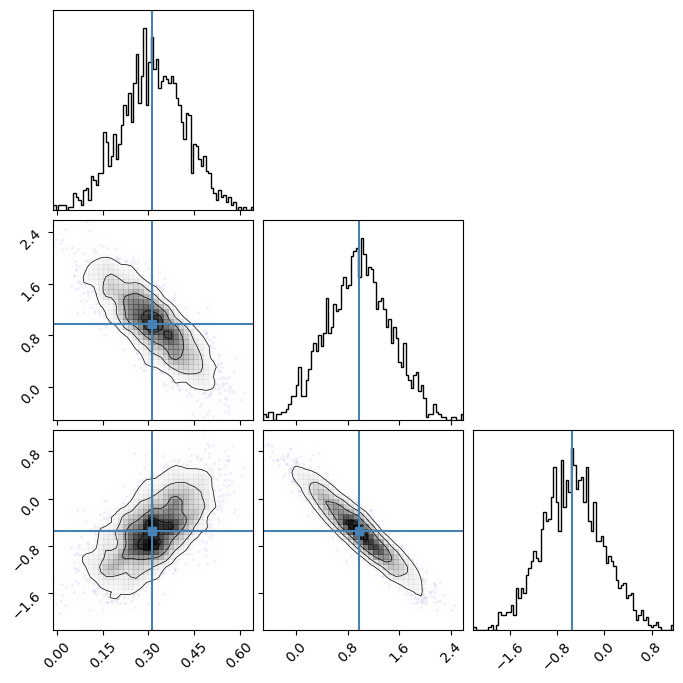

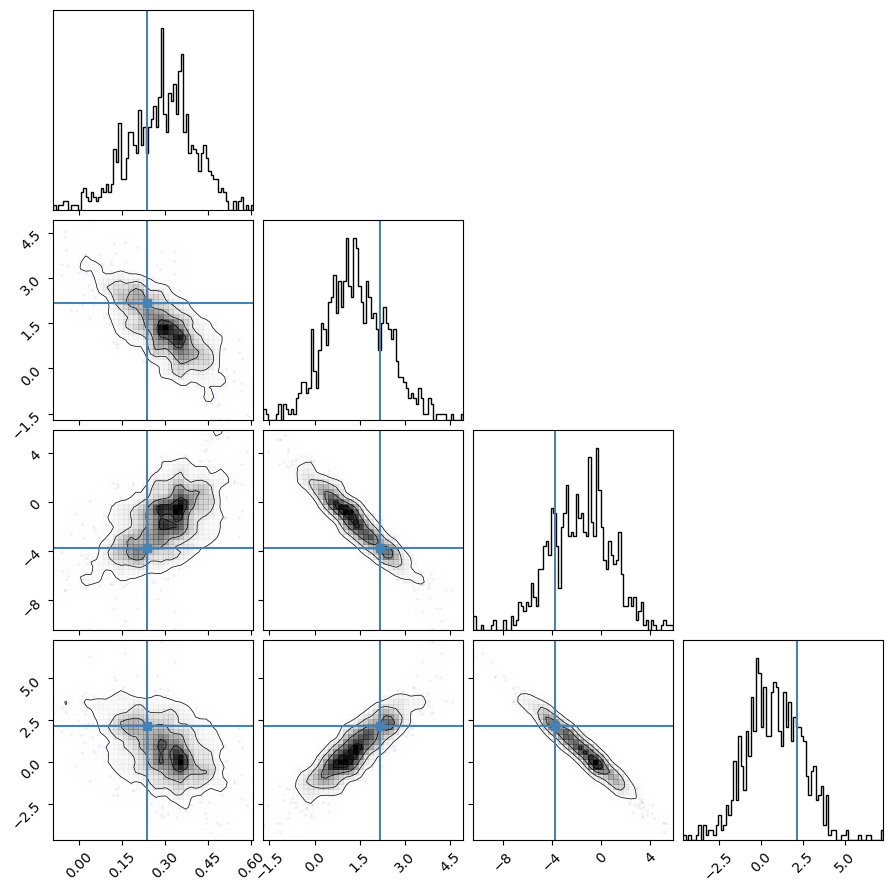

In [29]:
# corner plots to check sampling within each state
if(plotting):
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble,model_chain,states_chain = key.get_transc_samples(discard=0,thin=thin,flat=True,returnchains=True)
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "slateblue"}
    for i in range(1,nstates):
        string = 'Order '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1,ndims[i]), 
            truths=muplot[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

In [30]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n'
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 2856 samples in state 1
 10418 samples in state 2
 1899 samples in state 3
 
 [array([[0.52911797],
       [0.65660086],
       [0.57019589],
       ...,
       [0.63561627],
       [0.63012019],
       [0.57586214]], shape=(2856, 1)), array([[0.41822471, 0.45494848],
       [0.43806957, 0.30035073],
       [0.44195354, 0.26111077],
       ...,
       [0.3490181 , 0.57966952],
       [0.38139203, 0.6113567 ],
       [0.35809174, 0.58209051]], shape=(10418, 2)), array([[ 0.31346579,  0.95798495, -0.52398092],
       [ 0.45868877,  0.04613721,  0.4593347 ],
       [ 0.45006135,  0.35495443,  0.08526302],
       ...,
       [ 0.27105935,  0.64953276, -0.0372625 ],
       [ 0.30144731,  1.03957996, -0.80521965],
       [ 0.40100576,  0.84201254, -0.27779473]], shape=(1899, 3)), array([[ 0.25796257,  2.4415388 , -4.53029292,  2.60036068],
       [ 0.14286694,  1.29791646, -0.77814093, -0.02530032],
       [ 0.16262479,  1.44963883, -1.02234077,  0.0855207

---------